# Active Site Analysis

This example is adapted from the method used by [AntiSMASH](https://antismash.secondarymetabolites.org/#!/about) to annotate biosynthetic gene clusters. AntiSMASH uses profile HMMs to annotate enzymatic domains in protein sequences. By matching the amino acids in the alignment, it can then predict the product specificity of the enzyme. 

In this notebook, we show how to reproduce this kind of analysis, using a PKSI Acyltransferase domain built by the AntiSMASH authors (the HMM in HMMER2 format can be downloaded from [their git repository](https://github.com/antismash/antismash/blob/master/antismash/modules/active_site_finder/data/PKSI-AT.hmm2)). For more information about this profile HMM, you can have a look at the reference paper:

> [Del Vecchio, F., H. Petkovic, S. G. Kendrew, L. Low, B. Wilkinson, R. Lill, J. Cortes, B. A. Rudd, J. Staunton, and P. F. Leadlay. 2003. Active-site residue, domain and module swaps in modular polyketide synthases. J Ind. Microbiol Biotechnol 30:489-494.](https://pubmed.ncbi.nlm.nih.gov/12811585/)

In [1]:
import pyhmmer
pyhmmer.__version__

'0.1.0-a4'

## Loading the HMM

Loading a HMMER profile is done with the `pyhmmer.plan7.HMMFile` class, which provides an iterator over the HMMs in the file. Since we only use a single HMM, we can simply use `next` to get the first (and only) `pyhmmer.plan7.HMM` in the file. 

In [2]:
with pyhmmer.plan7.HMMFile("data/hmm/PKSI-AT.hmm2") as hmm_file:
    hmm = next(hmm_file)

## Building digitized sequences

Easel provides the code necessary to load sequences from files in common biological formats, such as GenBank or FASTA. These utilities are wrapped by the `pyhmmer.easel.SequenceFile`, which provides an iterator over the sequences in the file. Note that `SequenceFile` tries to guess the format by default, but you can force a particular format with the `format` keyword argument.

In [3]:
with pyhmmer.easel.SequenceFile("data/seqs/PKSI.faa") as seq_file:
    sequences = [ seq.digitize(hmm.alphabet) for seq in seq_file ]

<div class="alert alert-info">

Note

The C interface of Easel allows storing a sequence in two different modes: in _text_ mode, where the sequence letters are represented as individual characters (e.g. "A" or "Y"), and _digital_ mode, where sequence letters are encoded into digits. To make Python programs clearer, and to allow static typecheck of the storage mode, we provide two separate classes, `TextSequence` and `DigitalSequence`, that represent a sequence store in either of these modes.

</div>

`SequenceFile` yields sequences in text mode, but HMMER expects sequences in digital mode, so we must digitize them. This requires the sequence alphabet to be known, but we can just use the `Alphabet` instance stored in the `alphabet` attribute of `hmm`.   

## Running a search pipeline

In [4]:
pipeline = pyhmmer.plan7.Pipeline(hmm.alphabet)
hits = pipeline.search(hmm, sequences)

## Rendering the alignments

In [5]:
for i, hit in enumerate(hits):
    for domain in hit.domains:
        ali = domain.alignment
        print(" "*3, ali.target_name.decode())
        print("{:3}".format(ali.hmm_from), ali.hmm_sequence, "{:3}".format(ali.hmm_to))
        print(" "*3, ali.identity_sequence)
        print("{:3}".format(ali.target_from), ali.target_sequence, "{:3}".format(ali.target_to))
        print(" "*3, ali.hmm_name.decode())
        print()

    sp|Q9ZGI5|PIKA1_STRVZ
  1 lFpGQGsQyaGMGreLYetePVFRqalDrCaaaLrphLgfsLlevLfgdegqeeaaaslLdqTryaQPALFAvEYALArLWrSWGvePdAVlGHSvGEyvAAcvAGVlSLEDALrLVaaRGrLMqa.lpggGaMlaVraseeevrelLapyggrlsiAAvNGPrsvVvSGdaeaieallaeLeaqGirarrLkVsHAFHSplMepmldeleevlagitpraPriPliSnvTGewltgeealdpaYWarhlRePVrFadgletLlaelGctvFlEvGPhpvLtalarrtlgesagtngadaawlaSLrrg 308
    +FpGQG+Q+aGMG eL++++ VF++a+ +C+aaL+p++++sL +v ++ +g     a+ L++++++QP+ FAv+++LAr W+  Gv+P+AV+GHS+GE++AA+vAG+lSL+DA+r+V  R++ ++a l+g+G+Ml+ ++se+ v e+La+++ +ls+AAvNGP ++VvSGd+ +ie+l++++ea G+rar ++V++A+HS+++e +  el+evlag++p+aPr+P++S++ G+w+t+  +ld++YW+r+lR+ V Fa+++etL+ + G+t+F+Ev++hpvLt ++  t            + la+Lrr+
635 VFPGQGTQWAGMGAELLDSSAVFAAAMAECEAALSPYVDWSLEAVVRQAPG-----APTLERVDVVQPVTFAVMVSLARVWQHHGVTPQAVVGHSQGEIAAAYVAGALSLDDAARVVTLRSKSIAAhLAGKGGMLSLALSEDAVLERLAGFD-GLSVAAVNGPTATVVSGDPVQIEELARACEADGVRARVIPVDYASHSRQVEIIESELAEVLAGLSPQAPRVPFFSTLEGAWITE-PVLDGGYWYRNLRHRVGFAPAVETLATDEGFTHFVEVSAHPVLTMALPGTV-----------TGLATLRRD 925
    PKS-AT.tcoffee

    

<Figure size 432x288 with 0 Axes>

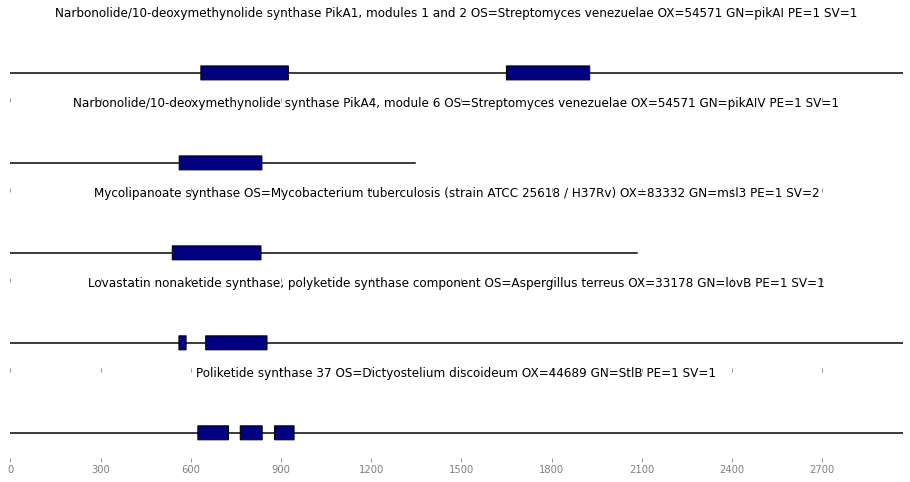

In [6]:
from dna_features_viewer import GraphicFeature, GraphicRecord
import matplotlib.pyplot as plt

plt.figure(1)
fig, axes = plt.subplots(nrows=len(hits), figsize=(16, 8), sharex=True)

seq_index = { seq.name:seq for seq in sequences }
for ax, hit in zip(axes, hits):
    
    features = [
        GraphicFeature(start=d.alignment.target_from-1, end=d.alignment.target_to)
        for d in hit.domains
    ]
        
    length = len(seq_index[hit.name])
    desc = seq_index[hit.name].description.decode()
    
    record = GraphicRecord(sequence_length=length, features=features)
    record.plot(ax=ax)
    ax.set_title(desc)

## Checking individual positions for catalytic activity

In [7]:
def iter_target_match(alignment):
    position = alignment.hmm_from
    for hmm_letter, amino_acid in zip(alignment.hmm_sequence, alignment.target_sequence):
        if hmm_letter != ".":
            yield position, amino_acid      
            position += 1

In [8]:
POSITIONS   = [ 93,  94,  95, 120, 196, 198, 199, 227, 244, 245]
EXPECTED    = ['G', 'H', 'S', 'R', 'A', 'H', 'S', 'S', 'Y', 'W']
SPECIFICITY = [195, 197]


for hit in hits:
    print("In sequence {!r}:".format(hit.name.decode()))
    for domain in hit.domains:       
        aligned = dict(iter_target_match(domain.alignment))
        
        print("- Found PKSI-AT domain at positions {:4} to {:4}".format(domain.ali_from, domain.ali_to))        
        try:
            signature = [ aligned[x] for x in POSITIONS ]
            spec = [ aligned[x] for x in SPECIFICITY ] 
        except KeyError:
            print("  -> Domain likely too short")
            continue
        if signature != EXPECTED:
            print("  -> Substrate specificity unknown")
        elif spec == ["H", "F"]:
            print("  -> Malonyl-CoA specific")
        elif spec == ["Y", "S"]:
            print("  -> Methylmalonyl-CoA specific")
        else:
            print("  -> Neither malonyl-CoA nor methylmalonyl-CoA specific")
    
    print()
            
            

In sequence 'sp|Q9ZGI5|PIKA1_STRVZ':
- Found PKSI-AT domain at positions  635 to  925
  -> Methylmalonyl-CoA specific
- Found PKSI-AT domain at positions 1651 to 1927
  -> Methylmalonyl-CoA specific
- Found PKSI-AT domain at positions 3181 to 3475
  -> Malonyl-CoA specific

In sequence 'sp|Q9ZGI2|PIKA4_STRVZ':
- Found PKSI-AT domain at positions  563 to  837
  -> Methylmalonyl-CoA specific

In sequence 'sp|A0A089QRB9|MSL3_MYCTU':
- Found PKSI-AT domain at positions  540 to  834
  -> Substrate specificity unknown

In sequence 'sp|Q9Y8A5|LOVB_ASPTE':
- Found PKSI-AT domain at positions  562 to  585
  -> Domain likely too short
- Found PKSI-AT domain at positions  651 to  854
  -> Neither malonyl-CoA nor methylmalonyl-CoA specific

In sequence 'sp|Q54FI3|STLB_DICDI':
- Found PKSI-AT domain at positions  625 to  726
  -> Domain likely too short
- Found PKSI-AT domain at positions  766 to  838
  -> Domain likely too short
- Found PKSI-AT domain at positions  880 to  944
  -> Domain likely t